In [1]:
%%capture
import os
os.environ["UNSLOTH_VLLM_STANDBY"] = "1" # [NEW] Extra 30% context lengths!
if "COLAB_" not in "".join(os.environ.keys()):
    # If you're not in Colab, just use pip install or uv pip install
    !pip install unsloth vllm
else:
    pass # For Colab / Kaggle, we need extra instructions hidden below \/


In [2]:
%%capture
import os
!pip install --upgrade -qqq uv
if "COLAB_" not in "".join(os.environ.keys()):
    # If you're not in Colab, just use pip install!
    !pip install unsloth vllm
else:
    try: import numpy, PIL; get_numpy = f"numpy=={numpy.__version__}"; get_pil = f"pillow=={PIL.__version__}"
    except: get_numpy = "numpy"; get_pil = "pillow"
    try: import subprocess; is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except: is_t4 = False
    get_vllm, get_triton = ("vllm==0.9.2", "triton==3.2.0") if is_t4 else ("vllm==0.10.2", "triton")
    !uv pip install -qqq --upgrade \
        unsloth {get_vllm} {get_numpy} {get_pil} torchvision bitsandbytes xformers
    !uv pip install -qqq {get_triton}
!uv pip install transformers==4.56.2
!uv pip install --no-deps trl==0.22.2
     

In [3]:
%%capture
!pip install -qqq fastapi uvicorn requests open_spiel
!git clone -b timeout-fix https://github.com/meta-pytorch/OpenEnv.git > /dev/null 2>&1
%cd OpenEnv
import subprocess, sys, os
from pathlib import Path
sys.path.insert(0, './src')
working_directory = str(Path.cwd().parent.absolute() / "OpenEnv")

In [4]:
%%capture
!pip install gymnasium ale-py autorom

In [5]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-3B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = False, # False for LoRA 16bit
    fast_inference = False, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.9, # Reduce if out of memory
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
#### Unsloth: `hf_xet==1.1.10` and `ipykernel>6.30.1` breaks progress bars. Disabling for now in XET.
#### Unsloth: To re-enable progress bars, please downgrade to `ipykernel==6.30.1` or wait for a fix to
https://github.com/huggingface/xet-core/issues/526
INFO 10-26 14:44:18 [__init__.py:225] Automatically detected platform rocm.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
==((====))==  Unsloth 2025.10.9: Fast Qwen2 patching. Transformers: 4.56.2. vLLM: 0.11.1rc3.dev39+gf417746ad.rocm700.
   \\   /|    . Num GPUs = 1. Max memory: 191.688 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0a0+git1c57644. ROCm Toolkit: 7.0.51831-a3e329ad8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - igno

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2, # *2 speeds up training
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    random_state = 3407,
)

Unsloth 2025.10.9 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [7]:
from envs.atari_env import AtariEnv
from envs.atari_env.models import AtariAction, AtariObservation

In [8]:
import ale_py
print(ale_py.roms.get_all_rom_ids())

['adventure', 'air_raid', 'alien', 'amidar', 'assault', 'asterix', 'asteroids', 'atlantis2', 'atlantis', 'backgammon', 'bank_heist', 'basic_math', 'battle_zone', 'beam_rider', 'berzerk', 'blackjack', 'bowling', 'boxing', 'breakout', 'carnival', 'casino', 'centipede', 'chopper_command', 'combat', 'crazy_climber', 'crossbow', 'darkchambers', 'defender', 'demon_attack', 'donkey_kong', 'double_dunk', 'earthworld', 'elevator_action', 'enduro', 'entombed', 'et', 'fishing_derby', 'flag_capture', 'freeway', 'frogger', 'frostbite', 'galaxian', 'gopher', 'gravitar', 'hangman', 'haunted_house', 'hero', 'human_cannonball', 'ice_hockey', 'jamesbond', 'journey_escape', 'joust', 'kaboom', 'kangaroo', 'keystone_kapers', 'king_kong', 'klax', 'koolaid', 'krull', 'kung_fu_master', 'laser_gates', 'lost_luggage', 'mario_bros', 'maze_craze', 'miniature_golf', 'montezuma_revenge', 'mr_do', 'ms_pacman', 'name_this_game', 'othello', 'pacman', 'phoenix', 'pitfall2', 'pitfall', 'pong', 'pooyan', 'private_eye', '

In [9]:
port = "8002"
localhost = f"http://localhost:{port}"
openenv_process = subprocess.Popen(
    [sys.executable, "-m", "uvicorn",
     "envs.atari_env.server.app:app",
     "--host", "0.0.0.0",
     "--port", port,
     "--log-level", "warning"],  # suppress INFO logs
    env={**os.environ,
         "PYTHONPATH": f"{working_directory}/src",
         "ATARI_GAME": "pitfall",
         "ATARI_REPEAT_ACTION_PROB": "0.25"},
    stdout=subprocess.DEVNULL,  # discard stdout
    stderr=subprocess.DEVNULL,  # discard stderr
    text=True,
    cwd=working_directory
)

# print(openenv_process.stderr.readline())

In [10]:
import requests
import time
time.sleep(5)
print(requests.get(f"{localhost}/health", timeout = 2).content)
openenv_process = AtariEnv(base_url = localhost)

b'{"status":"healthy"}'


In [11]:
result = openenv_process.reset()
current_state = result.observation

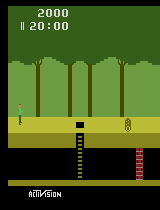

In [12]:
import numpy as np
from PIL import Image
def get_screen(observation):
    return np.array(observation.screen).reshape(observation.screen_shape)
    
def visualize_frame(screen):
    image = Image.fromarray(screen.astype(np.uint8))
    image.show()

visualize_frame(get_screen(result.observation))

In [13]:
from typing import Callable
from unsloth import execute_with_time_limit
import itertools

MAX_STEPS = 3000  # safety cap for one episode

def _execute_strategy(strategy: Callable, current_state: "AtariObservation"):

    assert callable(strategy), "Strategy must be a callable function"

    steps = 0
    total_reward = 2000
    completed = False
    reason = "running"
    while not current_state.done and steps < MAX_STEPS:
        screen = get_screen(current_state)

        try:
            action = int(strategy(screen))
        except Exception as e:
            print(str(e))
            return steps, total_reward - 2000, completed, current_state.lives

        if action not in current_state.legal_actions:
            return steps, total_reward - 1000, completed, current_state.lives

        action = AtariAction(action_id=action, game_name="pitfall")
        result = openenv_process.step(action)
        current_state = result.observation

        if result.reward is not None:
            total_reward += result.reward

        steps += 1 

    return steps, total_reward, current_state.done, current_state.lives


def execute_strategy(strategy: Callable, current_state: "AtariObservation"):
    return _execute_strategy(strategy, current_state)


In [14]:
def always_move_left(screen):
    return 4

# Reset OpenEnv to an initial state!
result = openenv_process.reset()
current_state = result.observation
try:
    steps, total_reward, if_done, lives = execute_strategy(always_move_left, current_state)
except TimeoutError as e:
    print(f"Timed out with error = {str(e)}")

steps, total_reward, if_done, lives

(294, 1976.0, True, 0)

In [15]:
prompt = """
Create a new short Pitfall Atari strategy using only native Python code.

You are given the current game screen as a NumPy array of shape (210, 160, 3),
representing the RGB frame of the Pitfall environment.

Your function must return one action ID (integer in string form) from this subset:
["1", "2", "3", "4", "5"]

where:
- "1" → FIRE (jump / start)
- "2" → UP (jump / climb up)
- "3" → RIGHT (move right)
- "4" → LEFT (move left)
- "5" → DOWN (climb down)

Goal: Maximize total score and avoid losing lives.
Instructions : Do not use any other libraries like numpy, only allowed to use standard python libraries.
Output your short function in backticks using the format below:
```python
def strategy(screen):
    return "3"  # Example: move right
```
All helper functions should be inside def strategy. Only output the short function `strategy`.
""".strip()

In [16]:
text = tokenizer.apply_chat_template(
    [{"role": "user", "content": prompt}],
    tokenize = False,
    add_generation_prompt = True,
    reasoning_effort = "low",
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    temperature = 1.0,
    max_new_tokens = 512,
    streamer = TextStreamer(tokenizer, skip_prompt = False),
)

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Create a new short Pitfall Atari strategy using only native Python code.

You are given the current game screen as a NumPy array of shape (210, 160, 3),
representing the RGB frame of the Pitfall environment.

Your function must return one action ID (integer in string form) from this subset:
["1", "2", "3", "4", "5"]

where:
- "1" → FIRE (jump / start)
- "2" → UP (jump / climb up)
- "3" → RIGHT (move right)
- "4" → LEFT (move left)
- "5" → DOWN (climb down)

Goal: Maximize total score and avoid losing lives.
Instructions : Do not use any other libraries like numpy, only allowed to use standard python libraries.
Output your short function in backticks using the format below:
```python
def strategy(screen):
    return "3"  # Example: move right
```
All helper functions should be inside def strategy. Only output the short function `strategy`.<|im_end|>
<|im_start|>assistant
``

In [17]:
from unsloth import create_locked_down_function
from unsloth import check_python_modules

In [18]:
def extract_function(text):
    if text.count("```") >= 2:
        first = text.find("```") + 3
        second = text.find("```", first)
        fx = text[first : second].strip()
        fx = fx.removeprefix("python\n")
        fx = fx[fx.find("def"):]
        if fx.startswith("def strategy(screen):"): return fx
    return None

print(extract_function(prompt))

def strategy(screen):
    return "3"  # Example: move right


In [19]:
def function_works(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 2000
        response = completion[0]["content"]
        function = extract_function(response)
        if function is not None:
            ok, info = check_python_modules(function)
        if function is None or "error" in info:
            score = -2.0
        else:
            try:
                new_strategy = create_locked_down_function(function)
                score = 1.0
            except:
                score = -0.5
        scores.append(score)
    return scores

In [20]:
def no_cheating(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        function = extract_function(response)
        if function is not None:
            ok, info = check_python_modules(function)
            scores.append(1.0 if ok else -20.0) # Penalize heavily!
        else:
            scores.append(-1.0) # Failed creating function
    return scores

In [21]:
import os

def reap_zombies():
    try:
        while True:
            pid, _ = os.waitpid(-1, os.WNOHANG)
            if pid == 0:
                break
    except ChildProcessError:
        pass

# Call reap_zombies() periodically in your training loop


In [22]:
import numpy as np
global PRINTER
PRINTER = 0

def strategy_succeeds(completions, **kwargs):
    global PRINTER
    scores = []
    reap_zombies()
    for completion in completions:
        printed = False
        score = 0
        response = completion[0]["content"]

        function = extract_function(response)

        # Print every 5 strategies for debugging
        if PRINTER % 5 == 0:
            printed = True
            print(function)
        PRINTER += 1

        if function is not None:
            ok, info = check_python_modules(function)

        if function is None or "error" in info:
            scores.append(0)
            continue

        try:
            new_strategy = create_locked_down_function(function)
        except:
            scores.append(0)
            continue

        try:
            # Reset OpenEnv to an initial state
            result = openenv_process.reset()
            current_state = result.observation

            # Execute strategy
            steps, total_reward, completed, lives = execute_strategy(new_strategy, current_state)
            
            if printed is False:
                print(function)

            print(f"Steps={steps}, TotalReward={total_reward}, Completed={completed}, Lives={lives}")

            scores.append(((total_reward / 114000) * 1000 + (lives / 3) * 10) / 10)

        except TimeoutError as e:
            print("Timeout")
            scores.append(-5.0)  # Penalize timeout heavily
        except Exception as e:
            print(f"Exception: {str(e)}")
            scores.append(-10.0)  # Penalize crashes heavily

    return scores


In [25]:
from datasets import Dataset
dataset = Dataset.from_list([{"prompt" : [{"role": "user", "content": prompt.strip()}], "answer" : 0, "reasoning_effort": "low"}]*1000)
maximum_length = len(tokenizer.apply_chat_template([{"role": "user", "content": prompt.strip()}], add_generation_prompt = True))
print(maximum_length)
dataset[2]

249


{'prompt': [{'content': 'Create a new short Pitfall Atari strategy using only native Python code.\n\nYou are given the current game screen as a NumPy array of shape (210, 160, 3),\nrepresenting the RGB frame of the Pitfall environment.\n\nYour function must return one action ID (integer in string form) from this subset:\n["1", "2", "3", "4", "5"]\n\nwhere:\n- "1" → FIRE (jump / start)\n- "2" → UP (jump / climb up)\n- "3" → RIGHT (move right)\n- "4" → LEFT (move left)\n- "5" → DOWN (climb down)\n\nGoal: Maximize total score and avoid losing lives.\nInstructions : Do not use any other libraries like numpy, only allowed to use standard python libraries.\nOutput your short function in backticks using the format below:\n```python\ndef strategy(screen):\n    return "3"  # Example: move right\n```\nAll helper functions should be inside def strategy. Only output the short function `strategy`.',
   'role': 'user'}],
 'answer': 0,
 'reasoning_effort': 'low'}

In [23]:
%%capture
!pip install trackio

In [26]:
max_prompt_length = maximum_length + 1 # + 1 just in case!
max_completion_length = max_seq_length - max_prompt_length

from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    temperature = 1.0,
    learning_rate = 5e-5,
    weight_decay = 0.01,
    warmup_ratio = 0.1,
    lr_scheduler_type = "linear",
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4, # Increase to 4 for smoother training
    num_generations = 2, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 500,
    save_steps = 100,
    report_to = "trackio", # Can use Weights & Biases, TrackIO
    output_dir = "outputs",

    # For optional training + evaluation
    # fp16_full_eval = True,
    # per_device_eval_batch_size = 4,
    # eval_accumulation_steps = 1,
    # eval_strategy = "steps",
    # eval_steps = 1,
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 2


In [27]:
# For optional training + evaluation
# new_dataset = dataset.train_test_split(test_size = 0.01)

trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        function_works,
        no_cheating,
        strategy_succeeds,
    ],
    args = training_args,
    train_dataset = dataset,

    # For optional training + evaluation
    # train_dataset = new_dataset["train"],
    # eval_dataset = new_dataset["test"],
)

In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 2 | Total steps = 500
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 119,734,272 of 3,205,672,960 (3.74% trained)


* Trackio project initialized: huggingface
* Trackio metrics logged to: /root/.cache/huggingface/trackio


* Created new run: dainty-sunset-0
def strategy(screen):
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)
    
    if sum(screen.sum(axis=1).sum(axis=0)) > 2000:  # Check for bright pixels on the screen
        return "1"  # Fire (jump/start)
    elif pygame.Rect(210, 0, 30, 100).colliderect(pygame.Rect(60, 40, 20, 20)):  # Check if player is on a jumpable surface
        return "2"  # Up (jump/climb up)
    elif 140 < screen[:, 159, 0] < 178:  # Check for green on the right edge (moving right)
        return "3"  # Right (move right)
    elif screen[:, 1, 0] < 127:  # Check for blue on the left edge (moving left)
        return "4"  # Left (move left)
    elif screen[50, 75, 1] > 50:  # Check for yellow on the bottom (climbing down)
        return "5"  # Down (climb down)
    else:
        return "3"  # Default to moving right if no conditions are met
Steps=3000, TotalReward=2000.0, Completed=False, Lives=3
name 'np' is not defined
def strategy(screen):
    screen_height, screen_widt

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / function_works / mean,rewards / function_works / std,rewards / no_cheating / mean,rewards / no_cheating / std,rewards / strategy_succeeds / mean,rewards / strategy_succeeds / std
1,0.000000,3.749561,0.800767,178.375000,131.000000,310.000000,0.000000,178.375000,131.000000,310.000000,0,0,0,0,0,0.002378,1.000000,0.000000,1.000000,0.000000,1.749561,0.868221
2,0.000000,3.519298,0.145143,170.750000,61.000000,236.000000,0.000000,170.750000,61.000000,236.000000,No Log,No Log,No Log,No Log,No Log,0.005665,1.000000,0.000000,1.000000,0.000000,1.519298,0.777915
3,0.000000,3.866228,0.635776,165.250000,101.000000,234.000000,0.000000,165.250000,101.000000,234.000000,No Log,No Log,No Log,No Log,No Log,0.005258,1.000000,0.000000,1.000000,0.000000,1.866228,0.926482
4,0.000000,3.866228,0.604762,114.500000,71.000000,205.000000,0.000000,114.500000,71.000000,205.000000,No Log,No Log,No Log,No Log,No Log,0.005014,1.000000,0.000000,1.000000,0.000000,1.866228,0.926482
5,0.000000,3.738596,1.044533,182.625000,60.000000,332.000000,0.000000,182.625000,60.000000,332.000000,No Log,No Log,No Log,No Log,No Log,0.003307,1.000000,0.000000,1.000000,0.000000,1.738597,0.854158
6,0.000000,0.675000,4.136575,157.500000,87.000000,211.000000,0.000000,157.500000,87.000000,211.000000,No Log,No Log,No Log,No Log,No Log,0.004578,1.000000,0.000000,-1.625000,7.424622,1.300000,0.608928
7,0.000000,4.021930,0.973823,164.625000,78.000000,287.000000,0.000000,164.625000,78.000000,287.000000,No Log,No Log,No Log,No Log,No Log,0.007489,1.000000,0.000000,1.000000,0.000000,2.021930,0.944568
8,0.000000,3.968860,0.490633,216.500000,96.000000,740.000000,0.000000,216.500000,96.000000,740.000000,No Log,No Log,No Log,No Log,No Log,0.008190,1.000000,0.000000,1.000000,0.000000,1.968860,0.873396
9,0.000100,3.646930,0.294628,177.625000,85.000000,430.000000,0.000000,177.625000,85.000000,430.000000,No Log,No Log,No Log,No Log,No Log,0.021766,1.000000,0.000000,1.000000,0.000000,1.646930,0.893258
10,0.000200,3.635965,0.310135,192.750000,88.000000,397.000000,0.000000,192.750000,88.000000,397.000000,No Log,No Log,No Log,No Log,No Log,0.040545,1.000000,0.000000,1.000000,0.000000,1.635965,0.878132


name 'np' is not defined
def strategy(screen):
    black = np.array([0, 0, 0])
    screen = screen.astype(np.float32)
    
    # Check for potential pitfall hazards
    if np.any(screen[:, 99:105] == black):
        return "4"  # LEFT
    
    if np.any(screen[:, 54:59] == black):
        return "2"  # UP
    
    if np.any(screen[:, 155:160] == black):
        return "5"  # DOWN
    
    if np.any(screen[10:12, 45:55] == black):
        return "1"  # FIRE
    
    return "3"  # RIGHT
Steps=0, TotalReward=0, Completed=False, Lives=3
name 'np' is not defined
def strategy(screen):
    speed = int(np.mean(screen[0:30, 50:150]))
    left_count = np.sum(screen[5:35, 8:10] == 255)
    right_count = np.sum(screen[5:35, 122:130] == 255)
    
    if speed > 150 and left_count > right_count:
        return "5"  # DOWN
    elif speed > 150 and left_count < right_count:
        return "3"  # RIGHT
    elif speed < 150:
        return "4"  # LEFT
    else:
        return "2"  # UP
Steps=0, TotalRew

In [ ]:
text = tokenizer.apply_chat_template(
    [{"role": "user", "content": prompt}],
    tokenize = False,
    add_generation_prompt = True,
    reasoning_effort = "low",
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    temperature = 1.0,
    max_new_tokens = 1024,
    streamer = TextStreamer(tokenizer, skip_prompt = False),
)

In [ ]:
# Merge and push to hub in mxfp4 4bit format
if False:
    model.save_pretrained_merged("finetuned_model", tokenizer, save_method = "mxfp4")
if False:
    model.push_to_hub_merged("repo_id/repo_name", tokenizer, token = "hf...", save_method = "mxfp4")

# Merge and push to hub in 16bit
if False:
    model.save_pretrained_merged("finetuned_model", tokenizer, save_method = "merged_16bit")
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/gpt-oss-finetune", tokenizer, save_method = "merged_16bit", token = "")